# Language figures

## Setup

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns

from icl.figures.plotting import WIDTH, HEIGHT, FULL_WIDTH, FULL_HEIGHT
from icl.constants import ANALYSIS, FIGURES

In [2]:
import warnings 
warnings.filterwarnings('ignore')

DEVICE = 'cpu'

data_path = ANALYSIS / 'language'

MAX_CHECKPOINT = 50000

MODEL_ID = "LM1"

color0 = cm.viridis(0.3)
color1 = cm.viridis(0.5)
color2 = cm.viridis(0.7)

sns.set_style("ticks")
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times'] + plt.rcParams['font.serif']
plt.rcParams['figure.dpi'] = 150


In [6]:
from typing import List, Literal, Tuple, Union

import numpy as np
import seaborn as sns
from matplotlib import patches as mpatches

PRIMARY, SECONDARY, TERTIARY = sns.color_palette()[:3]
BBLUE, BORANGE, BGREEN, BRED = sns.color_palette('bright')[:4]

TransitionType = Literal["A", "B", "Other"]
Transition = Union[Tuple[int, int, str, TransitionType], Tuple[int, int, str]]

TRANSITIONS_L1 = [
    (0, 400, 'A1'),
    (400, 900, 'B1'),
    (900, 15000, 'A2'),
    (15000, 50000, 'C1'),
]
TRANSITIONS_L2 = [
    (0, 900, 'A1'),
    (900, 6500, 'A2'),
    (6500, 8500, 'B2'),
    (8500, 17000, 'A3'),
    (17000, 50000, 'C1')
]

def gen_transition_colors(types: List[TransitionType]):
    """Generates a palette for transition colors. Orange-flavored for Type A. Blue-flavored for Type B."""
    num_type_a = sum([t == "A" for t in types])
    num_type_b = sum([t == "B" for t in types])
    num_other = sum([t == "Other" for t in types])

    type_a_palette = sns.color_palette("Oranges_r", num_type_a)
    type_b_palette = sns.color_palette("Blues_r", num_type_b)
    other_palette = sns.color_palette("Greys_r", num_other)

    palette = []

    for t in types:
        if t == "A":
            palette.append(type_a_palette.pop())
        elif t == "B":
            palette.append(type_b_palette.pop())
        else:
            palette.append(other_palette.pop())

    return palette


def get_transition_type(transition: Transition) -> TransitionType:
    if len(transition) == 4:
        return transition[-1]

    if "A" in transition[-1]:
        return "A"

    if "B" in transition[-1]:
        return "B"

    return "Other"



def plot_transitions(axes, transitions, max_step=np.inf, limit=False, alpha=0.2):
    types = [get_transition_type(m) for m in transitions]
    colors = gen_transition_colors(types)

    min_step = min([t[0] for t in transitions])
    max_step = min(max_step, max([t[1] for t in transitions]))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for ax in axes.flatten():
        for color, (start, end, label) in zip(colors, transitions):

            if start > max_step:
                continue

            ax.axvspan(start, min(end, max_step), alpha=alpha, label=label, color=color)

        if limit:
            ax.set_xlim(min_step, max_step)

    # Add transition legend
    patch_list = []

    stage_idx = 1
    for color, (start, end, label) in zip(colors, transitions):
        data_key = mpatches.Patch(color=color, alpha=0.2, label=f'LM{stage_idx}')
        patch_list.append(data_key)
        stage_idx += 1

    return patch_list

## Load in data

In [3]:
import pickle

def load_data(filename):
  with open(f'{data_path}/{filename}', 'rb') as file:
    return pickle.load(file)

L1_n_gram_losses = load_data('L1-n-grams.pkl')
L2_n_gram_losses = load_data('L2-n-grams.pkl')

L1_per_token_loss = load_data('L1-per-token-loss.pkl')
L1_per_token_loss_pos_ablated = load_data('L1-per-token-loss-pos-ablated.pkl')
L2_per_token_loss = load_data('L2-per-token-loss.pkl')
L2_per_token_loss_pos_ablated = load_data('L2-per-token-loss-pos-ablated.pkl')

L2_prev_scores = load_data('L2-prev-scores.pkl')
L2_prefix_scores = load_data('L2-prefix-scores.pkl')

L1_bigram_scores = load_data('L1-bigram-score.pkl')
L2_bigram_scores = load_data('L2-bigram-score.pkl')
bigram_entropy = load_data('bigram_entropy.pkl')

# mean test loss stored as -1
L1_losses = L1_per_token_loss[-1]
L2_losses = L2_per_token_loss[-1]

L1_norms = load_data('L1-norms.pkl')
L2_norms = load_data('L2-norms.pkl')

L1_pos_pca = load_data('L1-pos-weight-pcas.pkl')
L2_pos_pca = load_data('L2-pos-weight-pcas.pkl')

L1_pos_mags = load_data('L1-pos-magnitudes.pkl')
L2_pos_mags = load_data('L2-pos-magnitudes.pkl')

L1_llc_mean_df = pd.read_csv(f'{data_path}/L1-llc-mean.csv')
L1_llc_std_df = pd.read_csv(f'{data_path}/L1-llc-std.csv')
L1_llc_mean_df = L1_llc_mean_df[['Step', 'L1W256-3M-LLC-rr - llc/mean']]
L1_llc_mean_df = L1_llc_mean_df.rename(columns={'L1W256-3M-LLC-rr - llc/mean': 'llc_mean'})
print(L1_llc_mean_df.head())

L2_llc_mean_df = pd.read_csv(f'{data_path}/L2-llc-mean.csv')
L2_llc_std_df = pd.read_csv(f'{data_path}/L2-llc-std.csv')
L2_llc_mean_df = L2_llc_mean_df[['Step', 'L2W256-3M-LLC-rr - llc/mean']]
L2_llc_mean_df = L2_llc_mean_df.rename(columns={'L2W256-3M-LLC-rr - llc/mean': 'llc_mean'})
print(L2_llc_mean_df.head())

L2_icl_score_df = pd.read_csv(f'{data_path}/L2-icl-score.csv')
L2_icl_score_df = L2_icl_score_df[['Step', 'L2W256-3m-rr-ICL - icl-loss']]
L2_icl_score_df = L2_icl_score_df.rename(columns={'L2W256-3m-rr-ICL - icl-loss': 'icl_loss'})
print(L2_icl_score_df.head())

L2_k_comp_scores = load_data('L2-k-comp-scores.pkl')
L2_mean_k_comp = load_data('L2-mean-k-comp-score.pkl')

   Step    llc_mean
0     0  108.191154
1   100  113.079033
2   200  117.555618
3   300  118.215271
4   400  118.505104
   Step    llc_mean
0     0  123.559990
1   100  137.331192
2   200  143.640503
3   300  146.997894
4   400  148.288742
   Step  icl_loss
0     0 -0.122264
1   100 -0.067171
2   200 -0.079183
3   300 -0.077179
4   400 -0.069354


## Figures

### Figure 1

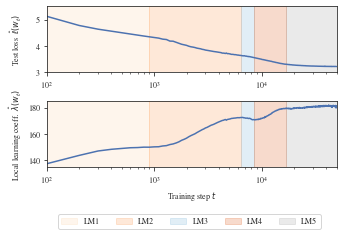

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_palette('deep')
# colors = gen_transition_colors(['A', 'A', 'B', 'A', 'Other']) # sns.color_palette("coolwarm_r", n_colors=len(TRANSITIONS))

# Create figure
fig, axs = plt.subplots(2, 1, figsize=(WIDTH * 1.5, HEIGHT * 1.5))

axs[0].set_ylabel(r'Test loss  $\hat{\ell}(w_t)$' '\n')
axs[1].set_ylabel(r'Local learning coeff.  $\hat\lambda(w_t)$')
# First line plot
df = pd.DataFrame({
    'step': list(range(0, 50_001, 100)),
    'loss': L2_losses,
})
sns.lineplot(df, x='step', y='loss', ax=axs[0])
axs[0].set_xscale('log')

# Second line plot
sns.lineplot(L2_llc_mean_df, x='Step', y='llc_mean', ax=axs[1])
axs[1].set_xscale('log')

# Set x-label for both plots
axs[0].set_xlabel('')
axs[1].set_xlabel('Training step $t$')

axs[0].set_ylim(3, 5.5)
axs[1].set_ylim(135, 185)
axs[0].set_xlim(100, 50_000)
axs[1].set_xlim(100, 50_000)

handles = plot_transitions(axs, TRANSITIONS_L2)

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.55, 0.01), ncol=len(TRANSITIONS_L2))

# Layout adjustments
plt.tight_layout()
fig.set_facecolor('white')

fig_name = 'lm-fig1-top.pdf'
fig.savefig(FIGURES / f"language/{fig_name}", bbox_inches='tight')
plt.show()

### Figure 3

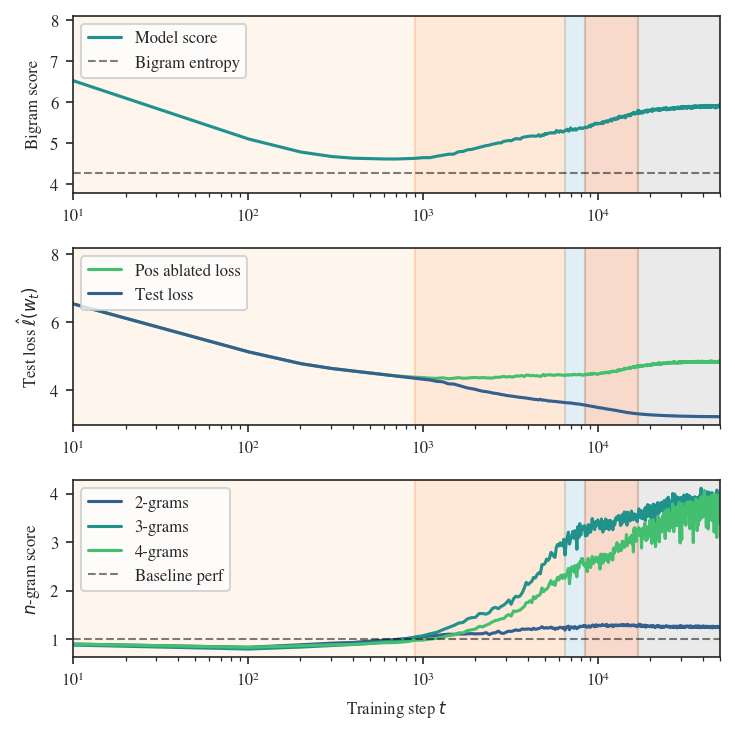

In [106]:
y_min = 3.8

x_steps = np.array(list(range(0, 50001, 100)))+1

fig, axs = plt.subplots(3, 1, figsize=(5, 5))
data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    'Bigram score': L2_bigram_scores,
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="Bigram score", label="Model score", ax=axs[0], color=color1)



data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    'Test loss': L2_per_token_loss_pos_ablated[-1],
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="Test loss", label="Pos ablated loss", ax=axs[1], color=color2)
axs[1].plot(x_steps, L2_per_token_loss[-1], label='Test loss', color=color0)
axs[1].set_ylabel('Test loss $\hat\ell(w_t)$')

# get n-gram vs per token loss stats
n_gram_improvement = {}
for i in range(2, 5):
  n_gram_improvement[i] = L2_per_token_loss[i] / np.array(L2_n_gram_losses[(i, 2)])

data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    '$n$-gram score': n_gram_improvement[2]
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="$n$-gram score", label="2-grams", ax=axs[2], color=color0)
axs[2].plot(x_steps, n_gram_improvement[3], label='3-grams', color=color1)
axs[2].plot(x_steps, n_gram_improvement[4], label='4-grams', color=color2)


for i in range(3):
  axs[i].set_xscale('log')
  axs[i].set_xlim(10, 50000)

axs[0].set_ylim(y_min, None)
axs[0].axhline(y=bigram_entropy, color='black', linestyle='--', linewidth=1, label='Bigram entropy', alpha=0.5)
axs[0].legend(loc='upper left')
axs[0].set_xlabel(None)

axs[1].legend(loc='upper left')
axs[1].set_xlabel(None)

axs[2].axhline(y=1, color='black', linestyle='--', linewidth=1, label='Baseline perf', alpha=0.5)
axs[2].legend(loc='upper left')
axs[2].set_xlabel('Training step $t$')

# axs[0].text(-0.15, 0.45, '(a)', transform=axs[0].transAxes, 
#             size=12, weight='bold')
# axs[1].text(-0.15, 0.45, '(b)', transform=axs[1].transAxes, 
#             size=12, weight='bold')
# axs[2].text(-0.15, 0.45, '(c)', transform=axs[2].transAxes, 
#             size=12, weight='bold')


plot_transitions(axs, TRANSITIONS_L2, limit=True)

plt.tight_layout()

fig_name = 'LM1-2.pdf'
fig.savefig(FIGURES / f"language/{fig_name}", bbox_inches='tight')
plt.show()

### Figure 4

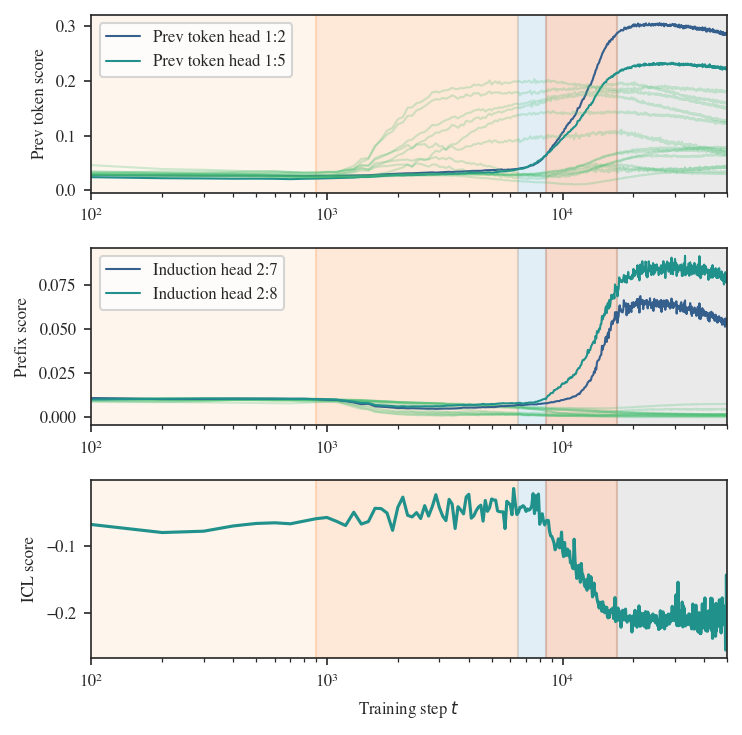

In [105]:
x_steps = np.array(list(range(0, 50001, 100)))

fig, axs = plt.subplots(3, 1, figsize=(5, 5))


for layer in range(2):
  for idx in range(8):
    head_scores = L2_prev_scores[:, layer, idx]
    label = None
    color = color2
    alpha = 0.25

    if layer == 0 and idx == 1:
      color = color0
      alpha = 1.0
      label = 'Prev token head 1:2'
    elif layer == 0 and idx == 4:
      color = color1
      alpha = 1.0
      label = 'Prev token head 1:5'

    data = pd.DataFrame({
        'Step, $\log{t}$': x_steps,
        'Prev token score': head_scores
    })
    sns.lineplot(data=data, x='Step, $\log{t}$', y='Prev token score', alpha=alpha, color=color, ax=axs[0], linewidth=1, label=label)

for layer in range(2):
  for idx in range(8):
    head_scores = L2_prefix_scores[:, layer, idx]
    label = None
    color = color2
    alpha = 0.25

    if layer == 1 and idx == 6:
      color = color0
      alpha = 1.0
      label='Induction head 2:7'
    elif layer == 1 and idx == 7:
      color = color1
      alpha = 1.0
      label='Induction head 2:8'

    data = pd.DataFrame({
        'Step, $\log{t}$': x_steps,
        'Prefix score': head_scores
    })
    sns.lineplot(data=data, x='Step, $\log{t}$', y='Prefix score', alpha=alpha, color=color, ax=axs[1], linewidth=1, label=label)


data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    'ICL score': L2_icl_score_df['icl_loss']
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="ICL score", ax=axs[2], color=color1)
axs[2].set_xlabel('Training step $t$')


axs[1].set_xlabel(None)
axs[0].set_xlabel(None)
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')

# axs[0].text(-0.2, 0.45, '(a)', transform=axs[0].transAxes, 
#             size=12, weight='bold')
# axs[1].text(-0.2, 0.45, '(b)', transform=axs[1].transAxes, 
#             size=12, weight='bold')
# axs[2].text(-0.2, 0.45, '(c)', transform=axs[2].transAxes, 
#             size=12, weight='bold')

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.set_xlim(100, 50000)
    plot_transitions(ax, TRANSITIONS_L2, limit=True)

plt.tight_layout()

fig_name = 'LM3-4.pdf'
fig.savefig(FIGURES / f"language/{fig_name}", bbox_inches='tight')
plt.show()

### Figure 13

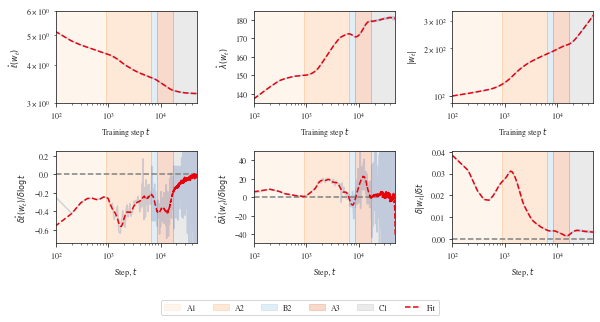

In [8]:
from matplotlib import lines as mlines
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from icl.figures.derivatives import d_dt

from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt

df = L2_llc_mean_df.merge(L2_llc_std_df, on='Step')
# Rename column Steps to step
df = df.rename(columns={'Step': 'step'})
df['weight/norm'] = L2_norms[:-1]
df['loss'] = L2_per_token_loss[-1][:-1]
steps = list(range(0, MAX_CHECKPOINT, 100))

metrics_to_plot = [
    (r"\hat\ell(w_t)", "loss", {"logy": True, "derivative": "d_dlogt", "spline": True, "s": 0.1}, ),
    # (r"L_\mathcal{G}(t)", df["true/mse"], {"logy": False}),
    (r"\hat \lambda(w_t)", 'llc_mean', {"derivative": "d_dlogt", "spline": True}),
    (r"|w_t|", "weight/norm", {"derivative": "d_dt", "logy": True, "spline": True, "s": 0.1}),
] 
fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(FULL_WIDTH * 1.25, FULL_HEIGHT * 2))

# axes = np.array(axes)
axes = axes.reshape(2, len(metrics_to_plot))

def str_dlog_dlogt(s):
    return r"$\delta \log " + s + r"/\delta\log t$"

for i, (metric_name, metric_key, kwargs) in enumerate(metrics_to_plot):
    use_spline = kwargs.get("spline", False)

    sns.lineplot(data=df, x="step", y=df[metric_key], ax=axes[0, i],label=metric_name, alpha=1 - use_spline * 0.75)
    # axes[0, i].plot(df['step'], metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(f"")
    axes[0, i].set_xlabel('Training step $t$')
    axes[0, i].set_ylabel(f"${metric_name}$")

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[0, i].legend().remove()

    slope_type = kwargs.get("derivative", "d_dlogt")

    if slope_type == "d_dlogt":
        slope_name = str_d_dlogt(metric_name)
        ys = d_dt(np.log(df['step'].values), df[metric_key].values)
    elif slope_type == "d_dt":
        slope_name = str_d_dt(metric_name)
        ys = d_dt(df['step'].values, df[metric_key].values)
    elif slope_type == "dlog_dlogt":
        slope_name = str_dlog_dlogt(metric_name)
        ys = d_dt(np.log(df['step'].values), np.log(df[metric_key].values))
    else:
        raise ValueError(f"Unknown slope type {slope_type}")

    sns.lineplot(data=df, x="step", y=ys, ax=axes[1, i], label=metric_name + " Slope", alpha=1 - use_spline * 0.75)
    axes[1, i].axhline(0, linestyle='--', color='gray')
    axes[1, i].set_title("")
    axes[1, i].set_xlabel('Step, $t$')
    axes[1, i].set_ylabel(slope_name)
    axes[1, i].legend().remove()

    if use_spline:     
        _steps = np.log(np.array(steps) + 1 ).reshape((-1, 1))
        _y = df.groupby('step').mean()[metric_key].values

        kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (5e-1, 1e3))

        # Create a Gaussian Process Regressor
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

        # Fit the Gaussian Process
        gp.fit(_steps, _y)
        _ypred = gp.predict(_steps)

        if slope_type == "d_dlogt":
            _derivy = d_dt(_steps, _ypred)
        elif slope_type == "d_dt":
            _derivy = d_dt(np.exp(_steps), _ypred)
        elif slope_type == "dlog_dlogt":            
            _derivy = d_dt(_steps, np.log(_ypred))
        
        axes[0, i].plot(steps, _ypred, label="Spline", linestyle='--', color=BRED)
        axes[1, i].plot(steps, _derivy, label="Spline", linestyle='--', color=BRED)



patch_list = plot_transitions(axes, TRANSITIONS_L2)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(100, 49_000)
    # ax.set_ylabel("")

# axes[1, 1].set_yscale('symlog')
# axes[1, 0].set_yscale('symlog')
# axes[0,0].set_ylim(0, 70)

milestone_labels = [label for _, _, label in TRANSITIONS_L2]
gp_fit_patch = mlines.Line2D([], [], color=BRED, linestyle='--', label="GP Fit")
fig.legend(patch_list + [gp_fit_patch], milestone_labels + ["Fit"], loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS_L2) + 1)

fig.set_facecolor("white")
fig.tight_layout()


# axes[0, 1].set_ylim(0, 100)
# axes[1, 0].set_ylim(-2.25, 2.25)
# axes[1, 1].set_ylim(-150, 160)
axes[0, 0].set_ylim(3, 6)
axes[0, 1].set_ylim(135, 185)
axes[1, 0].set_ylim(-.75, .25)
axes[1, 1].set_ylim(-50, 50)

fig.savefig(FIGURES / f"language/L2-loss-llc-with-slopes.pdf", bbox_inches='tight')
plt.show()

### Figure 15

In [9]:
import os
import torch
from huggingface_hub import HfApi
from transformer_lens import HookedTransformerConfig, HookedTransformer

# anonymized
HF_AUTHOR = 'oknMswoztTPaAVreBrWy'
HF_API = HfApi(
    endpoint="https://huggingface.co",
    token=os.environ['HF_API_KEY'] if 'HF_API_KEY' in os.environ else None,
)

model_cfgs = {}
model_cfgs[1] = HookedTransformerConfig(
    n_layers=1,
    d_model=256,
    d_head=32,
    n_heads=8,
    n_ctx=1024,
    d_vocab=5000,
    tokenizer_name='oknMswoztTPaAVreBrWy/TinyStories-tokenizer-5k',
    normalization_type='LN',
    attn_only=True,
    seed=1,
    positional_embedding_type='shortformer',
)

model_cfgs[2] = HookedTransformerConfig(
    n_layers=2,
    d_model=256,
    d_head=32,
    n_heads=8,
    n_ctx=1024,
    d_vocab=5000,
    tokenizer_name='oknMswoztTPaAVreBrWy/TinyStories-tokenizer-5k',
    normalization_type='LN',
    attn_only=True,
    seed=1,
    positional_embedding_type='shortformer',
)

def load_hf_checkpoint(step, n_layers=2):
  repo_id = f'{HF_AUTHOR}/L{n_layers}'
  checkpoint_name = f'checkpoint_{step:0>7d}.pth'
  model_path = HF_API.hf_hub_download(repo_id, repo_type='model', filename=f'checkpoints/{checkpoint_name}')
  state_dict = torch.load(model_path, map_location=torch.device(DEVICE))
  checkpoint = HookedTransformer(model_cfgs[n_layers])
  checkpoint.load_state_dict(state_dict)
  return checkpoint

In [14]:
import math
import torch.nn.functional as F

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def interpolate_color_html_non_linear(min_color, max_color, t, steepness=6.5):
    # Apply a sigmoid function for non-linear interpolation
    t = sigmoid((t - 0.5) * steepness)
    return 'rgb({},{},{})'.format(
        int(min_color[0] + (max_color[0] - min_color[0]) * t),
        int(min_color[1] + (max_color[1] - min_color[1]) * t),
        int(min_color[2] + (max_color[2] - min_color[2]) * t)
    )

def create_highlighted_html_text(word_tuples):
    # Warm and cold color extremes
    warm_color = (255, 0, 0)  # red
    cold_color = (0, 0, 255)  # blue
    background_color = (255, 255, 255)  # white
    soften_colors = 0.75

    # Convert word tuples into HTML string
    html_text = ""
    temperatures = [temp for _, temp in word_tuples]
    max_temp = max(temperatures)
    min_temp = min(temperatures)

    for word, temperature in word_tuples:
        if temperature > 0:  # warm
            color = interpolate_color_html_non_linear(background_color, warm_color, soften_colors * temperature / max_temp)
        elif temperature < 0:  # cold
            color = interpolate_color_html_non_linear(background_color, cold_color, soften_colors * -temperature / -min_temp)
        else:  # neutral
            color = interpolate_color_html_non_linear(background_color, background_color, 0)

        html_text += '<span style="background-color: {};">{}</span>'.format(color, word)

    return html_text

def get_log_prob_diffs(text, model_A, model_B):
  tokenized_text = model_A.to_tokens(text)
  logits_A = model_A(tokenized_text).detach()
  logits_B = model_B(tokenized_text).detach()
  logprobs_A = F.log_softmax(logits_A, dim=-1)
  logprobs_B = F.log_softmax(logits_B, dim=-1)
  logprob_diffs = []
  for idx in range(len(tokenized_text[0])-1):
    true_next_token = tokenized_text[0][idx+1].item()
    next_logprob_A = logprobs_A[0][idx][true_next_token].item()
    next_logprob_B = logprobs_B[0][idx][true_next_token].item()
    logprob_diffs.append(next_logprob_B - next_logprob_A)
  return logprob_diffs

def construct_word_tuples(text, model_A, model_B):
  logprob_diffs = get_log_prob_diffs(text, model_A, model_B)
  tokens = model_A.to_tokens(text)
  str_tokens = model_A.to_str_tokens(tokens)
  tuples = [(str_tokens[0], 0)] # start with bos_token
  for i in range(1, len(str_tokens)):
    diff = logprob_diffs[i-1]
    tuples.append((str_tokens[i], diff))
  return tuples

def compare_checkpoints(text, step_a, step_b):
  model_A = load_hf_checkpoint(step_a)
  model_B = load_hf_checkpoint(step_b)
  tuples = construct_word_tuples(text, model_A, model_B)
  html_text = create_highlighted_html_text(tuples)
  html_file_name = f'LM_highlighted_text_{step_a}-{step_b}.html'
  with open(FIGURES / 'visualizations' / html_file_name, 'w') as file:
    file.write(html_text)

In [11]:
# generate text (a)
sample_text_LM1 = '''I should like, before proceeding further, to tell you how I feel about the State which we have described. I might compare myself to a person who, on beholding beautiful animals either created by the painter's art, or, better still, alive but at rest, is seized with a desire of seeing them in motion or engaged in some struggle or conflict to which their forms appear suited;'''
compare_checkpoints(sample_text_LM1, 0, 900)

tokenizer_config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/65.7k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


checkpoint_0000900.pth:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


In [12]:
# generate text (b)
sample_text_LM2 = '''In the midst of unexpected circumstances with Linux and Python, the honorable Supreme Court in Boston delivered a ruling emphasizing a crazy database framework last week.'''
compare_checkpoints(sample_text_LM2, 900, 6500)

Using pad_token, but it is not set yet.


checkpoint_0006500.pth:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


In [13]:
# generate text(c)
sample_text_LM3 = "Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere."
compare_checkpoints(sample_text_LM3, 17000, 50000)

checkpoint_0017000.pth:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


checkpoint_0050000.pth:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


### Figure 16

<ipython-input-3-ded4e54ba135>:83: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


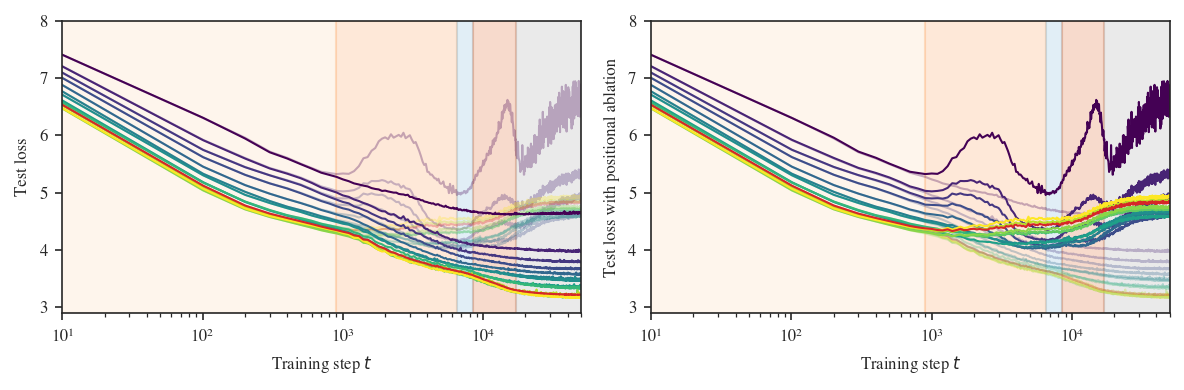

In [21]:
x_steps = np.array(list(range(0, 50001, 100)))+1

fig, axs = plt.subplots(1, 2, figsize=(8, 2.7))

POSITIONS = [2, 3, 5, 10, 20, 30, 50, 100, 200, 300, 500, 1000]

def pos_color(pos):
  return cm.viridis(np.log(pos) / np.log(1024))


data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    'loss': L2_per_token_loss_pos_ablated[1],
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="loss", ax=axs[0], color=pos_color(1), linewidth=1, alpha=0.3)
for pos in POSITIONS:
  axs[0].plot(x_steps, L2_per_token_loss_pos_ablated[pos], color=pos_color(pos), linewidth=1, alpha=0.3)
axs[0].plot(x_steps, L2_per_token_loss_pos_ablated[-1], color='tab:red', linewidth=1, alpha=0.3)

data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    'loss': L2_per_token_loss[1],
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="loss", ax=axs[0], color=pos_color(1), linewidth=1)
for pos in POSITIONS:
  axs[0].plot(x_steps, L2_per_token_loss[pos], color=pos_color(pos), linewidth=1)
axs[0].plot(x_steps, L2_per_token_loss[-1], color='tab:red', linewidth=1)


data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    'loss': L2_per_token_loss[1],
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="loss", ax=axs[1], color=pos_color(1), linewidth=1, alpha=0.3)
for pos in POSITIONS:
  axs[1].plot(x_steps, L2_per_token_loss[pos], color=pos_color(pos), linewidth=1, alpha=0.3)
axs[1].plot(x_steps, L2_per_token_loss[-1], color='tab:red', linewidth=1, alpha=0.3)

data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    'loss': L2_per_token_loss_pos_ablated[1],
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="loss", ax=axs[1], color=pos_color(1), linewidth=1)
for pos in POSITIONS:
  axs[1].plot(x_steps, L2_per_token_loss_pos_ablated[pos], color=pos_color(pos), linewidth=1)
axs[1].plot(x_steps, L2_per_token_loss_pos_ablated[-1], color='tab:red', linewidth=1)



for ax in axs.flatten():
    ax.set_xscale('log')
    ax.set_xlim(10, 50000)
    ax.set_ylim(None, 8)

axs[0].set_ylabel('Test loss')
axs[1].set_ylabel('Test loss with positional ablation')
axs[0].set_xlabel('Training step $t$')
axs[1].set_xlabel('Training step $t$')

plot_transitions(axs[0], TRANSITIONS_L2, limit=True)
plot_transitions(axs[1], TRANSITIONS_L2, limit=True)

plt.tight_layout()

fig_name = 'L2-per-token-loss-and-pos-ablation.pdf'
fig.savefig(FIGURES / f"language/{fig_name}", bbox_inches='tight')
plt.show()

### Figure 17

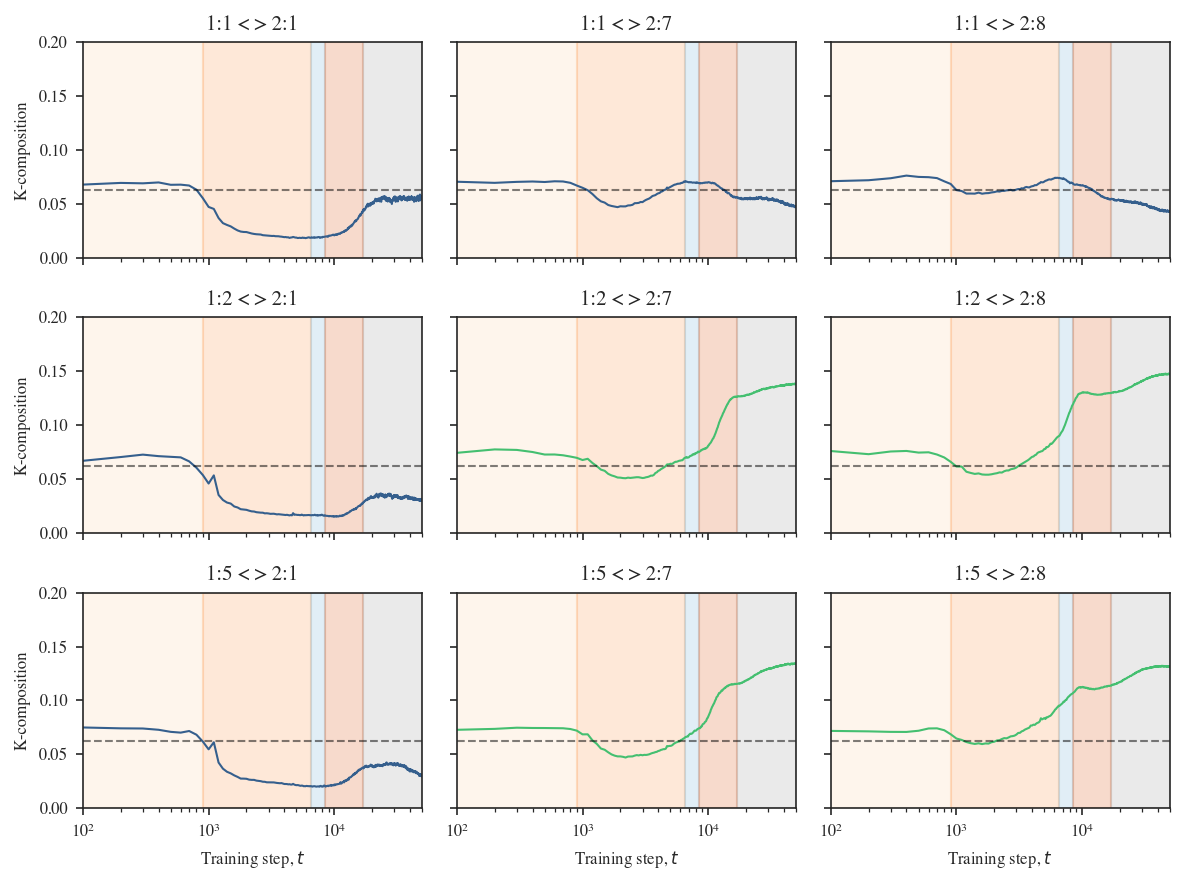

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import seaborn as sns
import numpy as np

fig, axs = plt.subplots(3, 3, figsize=(8, 6))

x_steps = list(range(0, 50001, 100))

y_min = 0
y_max = 0.2

layer1 = [0, 1, 4]
layer2 = [0, 6, 7]

def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

formatter = mticker.FuncFormatter(thousands_formatter)

for i in range(len(layer1)):
  for j in range(len(layer2)):
    h1 = layer1[i]
    h2 = layer2[j]
    ax = axs[i, j]

    vals = L2_k_comp_scores[(h1, h2)]
    data = pd.DataFrame({
        'Training step, $t$': x_steps,
        'K-composition': vals,
    })
    if i == 0 or j == 0:
      color = color0
    else:
      color = color2
    sns.lineplot(data=data, x='Training step, $t$', y='K-composition', color=color, ax=ax, linewidth=1)
    ax.axhline(y=L2_mean_k_comp.detach().numpy(), linestyle='--', color='black', alpha=0.5, linewidth=1)
    ax.set_title(f'1:{h1+1} < > 2:{h2+1}')
    plot_transitions(ax, TRANSITIONS_L2, limit=True)
    ax.set_xscale('log')
    ax.set_xlim(100, 50000)
    if i != 2:
      ax.set_xticklabels([])
      ax.set_xlabel('')
    if j != 0:
      ax.set_yticklabels([])
      ax.set_ylabel('')
    ax.set_ylim(y_min, y_max)

plt.tight_layout()

fig_name = 'k-compositions.pdf'
fig.savefig(FIGURES / f"language/{fig_name}", bbox_inches='tight')
plt.show()

### Figures L1 Appendix

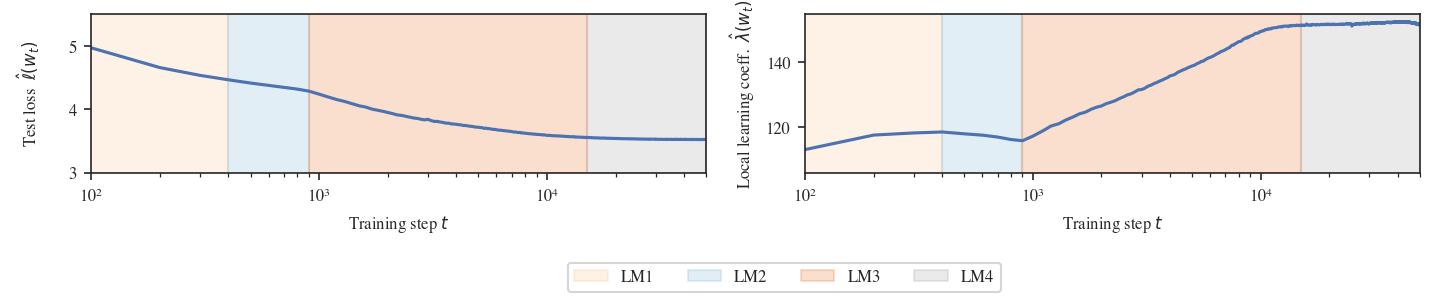

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_palette('deep')
# colors = gen_transition_colors(['A', 'A', 'B', 'A', 'Other']) # sns.color_palette("coolwarm_r", n_colors=len(TRANSITIONS))

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(WIDTH * 3, HEIGHT * 0.9))

axs[0].set_ylabel(r'Test loss  $\hat{\ell}(w_t)$' '\n')
axs[1].set_ylabel(r'Local learning coeff.  $\hat\lambda(w_t)$')
# First line plot
df = pd.DataFrame({
    'step': list(range(0, 50_001, 100)),
    'loss': L1_losses,
})
sns.lineplot(df, x='step', y='loss', ax=axs[0])
axs[0].set_xscale('log')

# Second line plot
sns.lineplot(L1_llc_mean_df, x='Step', y='llc_mean', ax=axs[1])
axs[1].set_xscale('log')

# Set x-label for both plots
axs[0].set_xlabel('Training step $t$')
axs[1].set_xlabel('Training step $t$')

axs[0].set_ylim(3, 5.5)
# axs[1].set_ylim(None, 185)
axs[0].set_xlim(100, 50_000)
axs[1].set_xlim(100, 50_000)

handles = plot_transitions(axs, TRANSITIONS_L1)

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.55, 0.01), ncol=len(TRANSITIONS_L2))

# Layout adjustments
plt.tight_layout()
fig.set_facecolor('white')

fig_name = 'L1-loss-llc.pdf'
fig.savefig(FIGURES / f"language/{fig_name}", bbox_inches='tight')
plt.show()

<ipython-input-32-193c420cf33c>:83: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


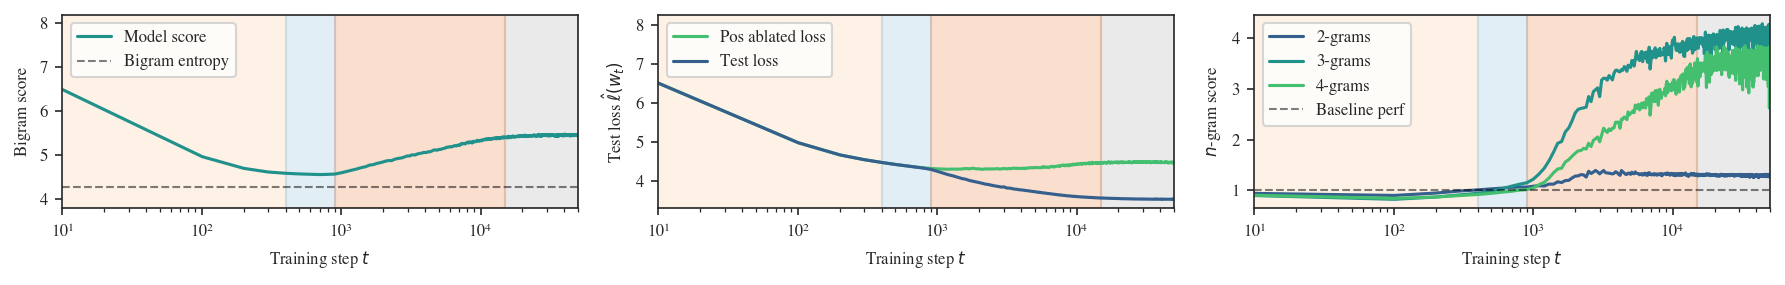

In [34]:
y_min = 3.8

x_steps = np.array(list(range(0, 50001, 100)))+1

fig, axs = plt.subplots(1, 3, figsize=(12, 2))

data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    'Bigram score': L1_bigram_scores,
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="Bigram score", label="Model score", ax=axs[0], color=color1)



data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    'Test loss': L1_per_token_loss_pos_ablated[-1],
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="Test loss", label="Pos ablated loss", ax=axs[1], color=color2)
axs[1].plot(x_steps, L1_per_token_loss[-1], label='Test loss', color=color0)
axs[1].set_ylabel('Test loss $\hat\ell(w_t)$')

# get n-gram vs per token loss stats
n_gram_improvement = {}
for i in range(2, 5):
  n_gram_improvement[i] = L1_per_token_loss[i] / np.array(L1_n_gram_losses[(i, 1)])

data = pd.DataFrame({
    'Step, $\log{t}$': x_steps,
    '$n$-gram score': n_gram_improvement[2]
})
sns.lineplot(data=data, x="Step, $\log{t}$", y="$n$-gram score", label="2-grams", ax=axs[2], color=color0)
axs[2].plot(x_steps, n_gram_improvement[3], label='3-grams', color=color1)
axs[2].plot(x_steps, n_gram_improvement[4], label='4-grams', color=color2)


for i in range(3):
  axs[i].set_xscale('log')
  axs[i].set_xlim(10, 50000)

axs[0].set_ylim(y_min, None)
axs[0].axhline(y=bigram_entropy, color='black', linestyle='--', linewidth=1, label='Bigram entropy', alpha=0.5)
axs[0].legend(loc='upper left')
axs[0].set_xlabel(None)
axs[0].set_xlabel('Training step $t$')

axs[1].legend(loc='upper left')
axs[1].set_xlabel(None)
axs[1].set_xlabel('Training step $t$')

axs[2].axhline(y=1, color='black', linestyle='--', linewidth=1, label='Baseline perf', alpha=0.5)
axs[2].legend(loc='upper left')
axs[2].set_xlabel('Training step $t$')


plot_transitions(axs, TRANSITIONS_L1, limit=True)

plt.tight_layout()

fig_name = 'LM1-2-L1.pdf'
fig.savefig(FIGURES / f"language/{fig_name}", bbox_inches='tight')
plt.show()

In [ ]:
from matplotlib import lines as mlines
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from icl.figures.derivatives import d_dt

from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt

df = L1_llc_mean_df.merge(L1_llc_std_df, on='Step')
# Rename column Steps to step
df = df.rename(columns={'Step': 'step'})
df['weight/norm'] = L1_norms[:-2]
df['loss'] = L1_per_token_loss[-1][:-2]
steps = list(range(0, MAX_CHECKPOINT, 100))[:-1]

metrics_to_plot = [
    (r"\hat\ell(w_t)", "loss", {"logy": True, "derivative": "d_dlogt", "spline": True, "s": 0.1}, ),
    # (r"L_\mathcal{G}(t)", df["true/mse"], {"logy": False}),
    (r"\hat \lambda(w_t)", 'llc_mean', {"derivative": "d_dlogt", "spline": True}),
    (r"|w_t|", "weight/norm", {"derivative": "d_dt", "logy": True, "spline": True, "s": 0.1}),
] 
fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(FULL_WIDTH * 1.25, FULL_HEIGHT * 2))

# axes = np.array(axes)
axes = axes.reshape(2, len(metrics_to_plot))

def str_dlog_dlogt(s):
    return r"$\delta \log " + s + r"/\delta\log t$"

for i, (metric_name, metric_key, kwargs) in enumerate(metrics_to_plot):
    use_spline = kwargs.get("spline", False)

    sns.lineplot(data=df, x="step", y=df[metric_key], ax=axes[0, i],label=metric_name, alpha=1 - use_spline * 0.75)
    # axes[0, i].plot(df['step'], metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(f"")
    axes[0, i].set_xlabel('Training step $t$')
    axes[0, i].set_ylabel(f"${metric_name}$")

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[0, i].legend().remove()

    slope_type = kwargs.get("derivative", "d_dlogt")

    if slope_type == "d_dlogt":
        slope_name = str_d_dlogt(metric_name)
        ys = d_dt(np.log(df['step'].values), df[metric_key].values)
    elif slope_type == "d_dt":
        slope_name = str_d_dt(metric_name)
        ys = d_dt(df['step'].values, df[metric_key].values)
    elif slope_type == "dlog_dlogt":
        slope_name = str_dlog_dlogt(metric_name)
        ys = d_dt(np.log(df['step'].values), np.log(df[metric_key].values))
    else:
        raise ValueError(f"Unknown slope type {slope_type}")

    sns.lineplot(data=df, x="step", y=ys, ax=axes[1, i], label=metric_name + " Slope", alpha=1 - use_spline * 0.75)
    axes[1, i].axhline(0, linestyle='--', color='gray')
    axes[1, i].set_title("")
    axes[1, i].set_xlabel('Step, $t$')
    axes[1, i].set_ylabel(slope_name)
    axes[1, i].legend().remove()

    if use_spline:     
        _steps = np.log(np.array(steps) + 1 ).reshape((-1, 1))
        _y = df.groupby('step').mean()[metric_key].values

        kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (5e-1, 1e3))

        # Create a Gaussian Process Regressor
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

        # Fit the Gaussian Process
        gp.fit(_steps, _y)
        _ypred = gp.predict(_steps)

        if slope_type == "d_dlogt":
            _derivy = d_dt(_steps, _ypred)
        elif slope_type == "d_dt":
            _derivy = d_dt(np.exp(_steps), _ypred)
        elif slope_type == "dlog_dlogt":            
            _derivy = d_dt(_steps, np.log(_ypred))
        
        axes[0, i].plot(steps, _ypred, label="Spline", linestyle='--', color=BRED)
        axes[1, i].plot(steps, _derivy, label="Spline", linestyle='--', color=BRED)



patch_list = plot_transitions(axes, TRANSITIONS_L1)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(100, 49_000)
    # ax.set_ylabel("")

# axes[1, 1].set_yscale('symlog')
# axes[1, 0].set_yscale('symlog')
# axes[0,0].set_ylim(0, 70)

milestone_labels = [label for _, _, label in TRANSITIONS_L1]
gp_fit_patch = mlines.Line2D([], [], color=BRED, linestyle='--', label="GP Fit")
fig.legend(patch_list + [gp_fit_patch], milestone_labels + ["Fit"], loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS_L1) + 1)

fig.set_facecolor("white")
fig.tight_layout()


# axes[0, 1].set_ylim(0, 100)
# axes[1, 0].set_ylim(-2.25, 2.25)
# axes[1, 1].set_ylim(-150, 160)
axes[0, 0].set_ylim(3, 6)
# axes[0, 1].set_ylim(135, 185)
axes[1, 0].set_ylim(-.75, .25)
axes[1, 1].set_ylim(-50, 50)

fig.savefig(FIGURES / f"language/L1-loss-llc-with-slopes.pdf", bbox_inches='tight')
plt.show()

### Figures Positional Embedding

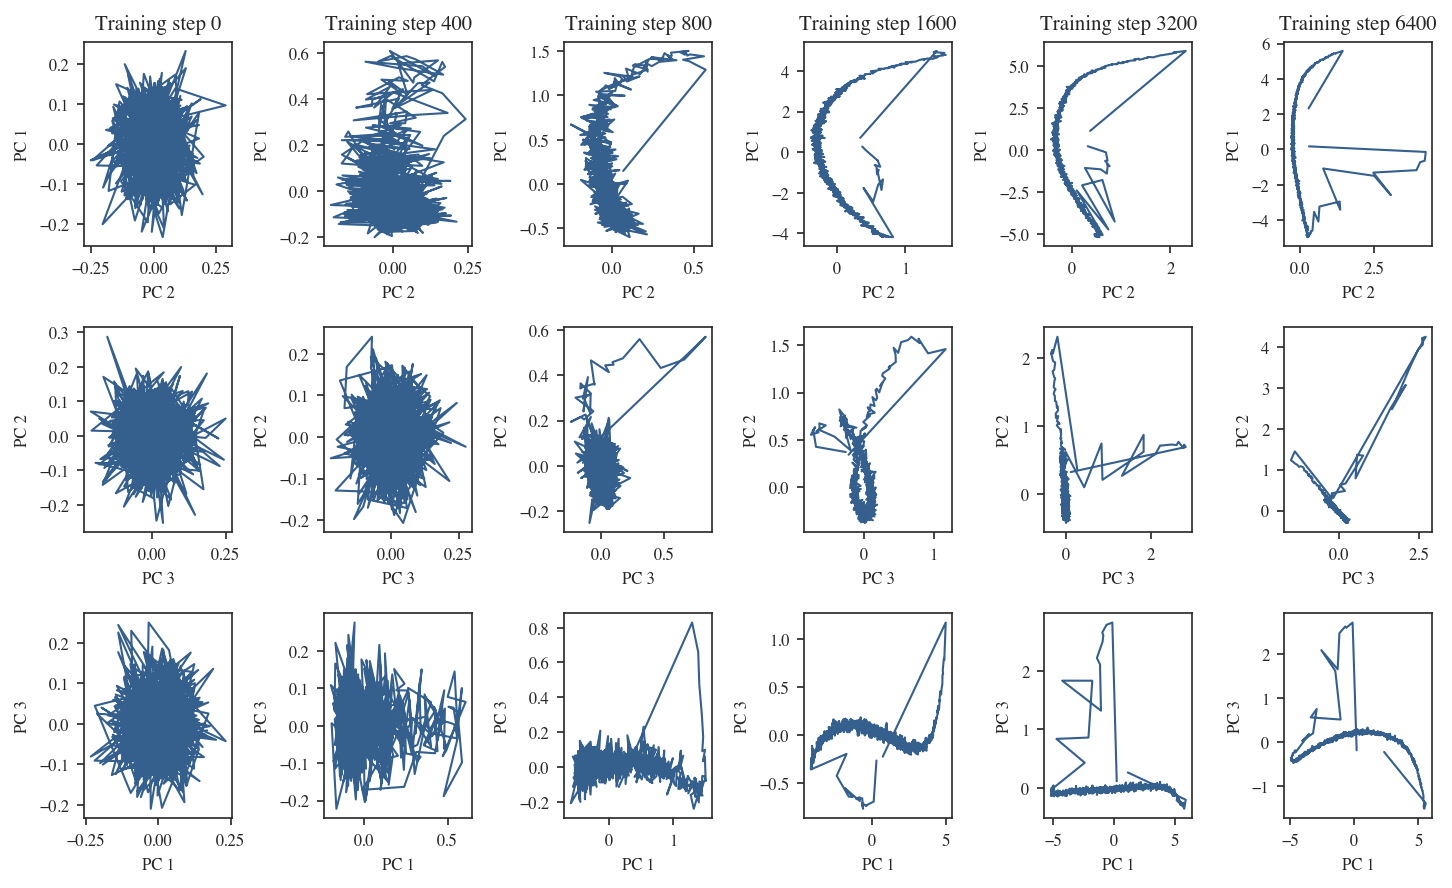

In [63]:
L1_checkpoints = [0, 4, 8, 16, 32, 64]

fig, axs = plt.subplots(3, len(L1_checkpoints), figsize=(WIDTH * 3, HEIGHT * 3))

for pc in range(3):
  for i, step in enumerate(L1_checkpoints):
    data = L1_pos_pca[step]['fit_data']
    pc1 = pc
    pc2 = (pc + 1) % 3
    axs[pc, i].plot(data[:, pc2], data[:, pc1], linewidth=1, color = color0)
    axs[pc, i].set_ylabel(f'PC {pc1+1}')
    axs[pc, i].set_xlabel(f'PC {pc2+1}')

for i in range(len(L1_checkpoints)):
  axs[0, i].set_title(f'Training step {L1_checkpoints[i]* 100}')

plt.tight_layout()

fig_name = 'L1-pos-pca.pdf'
fig.savefig(FIGURES / f"language/{fig_name}", bbox_inches='tight')
plt.show()

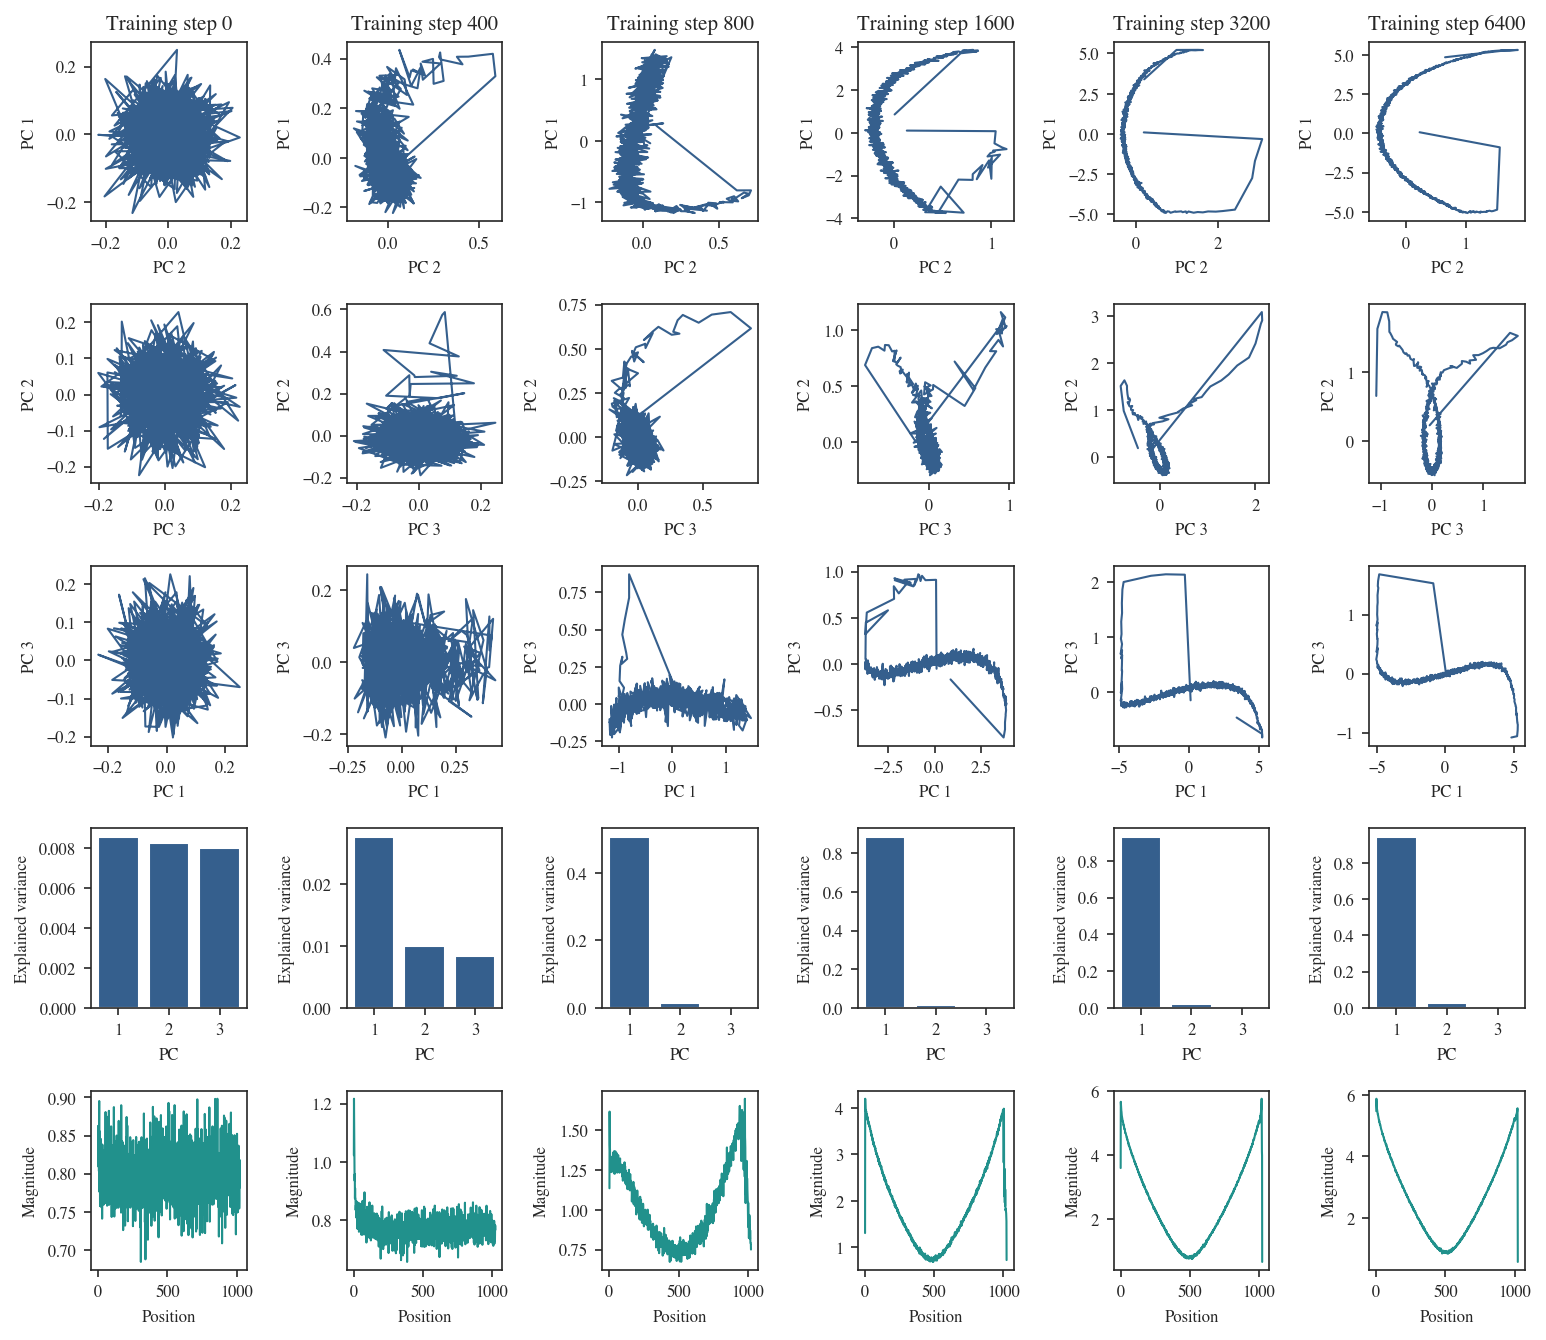

In [76]:
L2_checkpoints = [0, 4, 8, 16, 32, 64]

fig, axs = plt.subplots(5, len(L2_checkpoints), figsize=(WIDTH * 3.2, HEIGHT * 4.5))

for pc in range(3):
  for i, step in enumerate(L2_checkpoints):
    data = L2_pos_pca[step]['fit_data']
    pc1 = pc
    pc2 = (pc + 1) % 3
    axs[pc, i].plot(data[:, pc2], data[:, pc1], linewidth=1, color = color0)
    axs[pc, i].set_ylabel(f'PC {pc1+1}')
    axs[pc, i].set_xlabel(f'PC {pc2+1}')

for i, step in enumerate(L2_checkpoints):
  # explained variance bar charts
  data = L2_pos_pca[step]['ex_var']
  axs[3, i].bar(range(1, len(data)+1), data, color=color0)
  axs[3, i].set_ylabel('Explained variance')
  axs[3, i].set_xlabel('PC')
  # fix x ticks
  axs[3, i].set_xticks(range(1, len(data)+1))

  # magnitudes 
  data = L2_pos_mags[step]
  axs[4, i].plot(data, linewidth=1, color = color1)
  axs[4, i].set_ylabel('Magnitude')
  axs[4, i].set_xlabel('Position')

for i in range(len(L2_checkpoints)):
  axs[0, i].set_title(f'Training step {L2_checkpoints[i]* 100}')

plt.tight_layout()

fig_name = 'L2-pos-pca.pdf'
fig.savefig(FIGURES / f"language/{fig_name}", bbox_inches='tight')
plt.show()